### This notebook demonstrates how to build a very simple model using XGBoost for Video Popularity Prediction competition

In [ ]:
# Load libraries
import os
import pandas as pd
import numpy as np
import math
import random
import collections
import timeit
import xgboost as xgb
import sklearn.metrics

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# Check current directory and list all files in the directory.
os.getcwd()
os.listdir()

['.config', 'drive', 'sample_data']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.getcwd()

'/content'

In [ ]:
# Load training datasets
desc_train = pd.read_csv('/content/drive/MyDrive/Dataset/Description Data/train_desc_df.csv')
meta_train = pd.read_csv('/content/drive/MyDrive/Dataset/Metadata/train_meta_df.csv')
image_train = pd.read_csv('/content/drive/MyDrive/Dataset/Image Data/train_image_df.csv')
title_train = pd.read_csv('/content/drive/MyDrive/Dataset/Title Data/train_title_df.csv')

# Load public datasets (datasets used for the rankings)
desc_test = pd.read_csv('/content/drive/MyDrive/Dataset/Description Data/public_desc_df.csv')
meta_test = pd.read_csv('/content/drive/MyDrive/Dataset/Metadata/public_meta_df.csv')
image_test = pd.read_csv('/content/drive/MyDrive/Dataset/Image Data/public_image_df.csv')
title_test = pd.read_csv('/content/drive/MyDrive/Dataset/Title Data/public_title_df.csv')

print('Dimension of train description data is', desc_train.shape)
print('Dimension of train meta data is', meta_train.shape)
print('Dimension of train image data is', image_train.shape)
print('Dimension of train title data is', title_train.shape)

print('')

print('Dimension of test description data is', desc_test.shape)
print('Dimension of test meta data is', meta_test.shape)
print('Dimension of test image data is', meta_test.shape)
print('Dimension of test title data is', title_test.shape)

Dimension of train description data is (3000, 51)
Dimension of train meta data is (3000, 14)
Dimension of train image data is (3000, 4001)
Dimension of train title data is (3000, 51)

Dimension of test description data is (986, 51)
Dimension of test meta data is (986, 13)
Dimension of test image data is (986, 13)
Dimension of test title data is (986, 51)


In [ ]:
meta_train.head()

,comp_id,ad_blocked,embed,ratio,duration,language,partner,partner_active,n_likes,views,n_tags,n_formats,dayofweek,hour
0,1,False,True,1.77778,86,3,True,False,0,290,3,0,5,6
1,2,False,True,1.33333,1129,2,True,False,0,1443,0,2,5,6
2,3,False,True,1.76667,1163,2,True,False,0,329,0,1,5,6
3,4,False,True,1.77778,1326,2,True,False,0,63,0,3,5,6
4,5,False,True,1.77273,2612,2,True,False,3,37,0,0,5,6


In [ ]:
# Now look at the data structure.
desc_train.head()

,comp_id,desc_1,desc_2,desc_3,desc_4,desc_5,desc_6,desc_7,desc_8,desc_9,desc_10,desc_11,desc_12,desc_13,desc_14,desc_15,desc_16,desc_17,desc_18,desc_19,desc_20,desc_21,desc_22,desc_23,desc_24,desc_25,desc_26,desc_27,desc_28,desc_29,desc_30,desc_31,desc_32,desc_33,desc_34,desc_35,desc_36,desc_37,desc_38,desc_39,desc_40,desc_41,desc_42,desc_43,desc_44,desc_45,desc_46,desc_47,desc_48,desc_49,desc_50
0,1,-0.009555,0.002479,0.002927,0.015774,-0.008177,-0.016036,0.026697,-0.000106,0.025788,0.052237,0.028440,-0.085249,0.007856,-0.000305,0.008731,-0.068400,0.003454,0.001329,0.013231,-0.007687,0.030407,-0.001134,0.000494,-6.461385,0.038131,0.026232,-0.001567,0.009113,0.016394,-0.005538,-0.009708,-0.013093,-0.005617,0.006824,0.012795,-0.021388,-0.105503,0.006901,0.000284,0.027454,-0.029430,-0.029423,0.052256,0.007814,0.023472,-0.021134,0.003324,-0.004393,0.004294,-0.002223
1,2,-0.009555,0.002479,0.002927,0.015774,-0.008177,-0.016036,0.026697,-0.000106,0.025788,0.052237,0.028440,-0.085249,0.007856,-0.000305,0.008731,-0.068400,0.003454,0.001329,0.013231,-0.007687,0.030407,-0.001134,0.000494,-6.461385,0.038131,0.026232,-0.001567,0.009113,0.016394,-0.005538,-0.009708,-0.013093,-0.005617,0.006824,0.012795,-0.021388,-0.105503,0.006901,0.000284,0.027454,-0.029430,-0.029423,0.052256,0.007814,0.023472,-0.021134,0.003324,-0.004393,0.004294,-0.002223
2,3,-0.356706,0.213562,0.252663,0.090735,0.328961,-0.482705,0.067300,0.384217,-0.147253,-0.463378,-0.175824,2.032145,-0.143330,-0.394972,-0.157462,0.245942,0.405734,0.010298,-0.601022,-0.022109,0.284740,0.170112,-0.057594,3.057399,-0.146002,0.143649,0.914032,-0.035008,-0.156502,0.083768,0.597216,0.656176,-0.071332,0.730609,0.038204,-0.837585,-0.977806,0.663729,0.014156,0.530039,-0.626436,-0.102908,0.576792,-0.805986,0.310637,0.422263,0.403496,0.264240,7.057590,-0.252417
3,4,-0.294013,0.165262,0.257102,0.421037,0.463214,-0.769155,0.159450,0.236385,-0.183974,-0.357842,-0.051879,2.339253,-0.136640,-0.248848,-0.404962,0.199895,0.182226,0.033816,-0.706218,0.130868,0.501670,0.186079,-0.162675,3.070982,-0.032498,0.068264,1.034647,0.028793,-0.244596,0.037327,0.607908,0.415434,0.059239,0.319092,0.092515,-0.831052,-0.817347,0.602119,-0.067764,0.176569,-0.435836,0.052975,0.108777,-0.599593,0.408430,0.591615,0.415667,0.334706,7.025648,-0.309093
4,5,-0.028657,0.157017,0.282709,-2.674227,-0.711383,2.259387,-0.162175,0.605468,0.712229,0.027828,-0.529120,1.597859,1.062390,0.169534,-0.207715,-1.352804,0.181599,0.210282,0.515549,-0.411344,0.509503,0.897175,-0.348758,2.843993,-0.599135,0.031930,-0.849955,0.012406,0.019594,-0.332295,0.389301,-0.292774,0.386677,-3.005544,0.383045,-0.167495,-0.326522,0.134930,0.089576,0.669632,-1.714496,0.297421,-0.097744,0.000669,-1.639307,0.244313,0.099975,0.371806,-2.259024,-0.131085


In [ ]:
meta_train.isnull().sum()

comp_id           0
ad_blocked        0
embed             0
ratio             0
duration          0
language          0
partner           0
partner_active    0
n_likes           0
views             0
n_tags            0
n_formats         0
dayofweek         0
hour              0
dtype: int64

In [ ]:
meta_train.dtypes

comp_id             int64
ad_blocked           bool
embed                bool
ratio             float64
duration            int64
language            int64
partner              bool
partner_active       bool
n_likes             int64
views               int64
n_tags              int64
n_formats           int64
dayofweek           int64
hour                int64
dtype: object

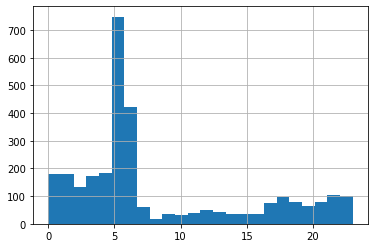

In [ ]:
meta_train['hour'].hist(bins=24)

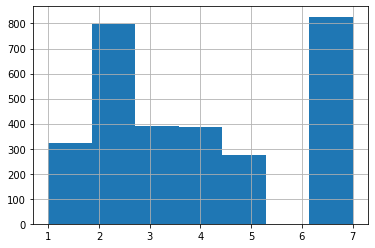

In [ ]:
meta_train['dayofweek'].hist(bins=7)

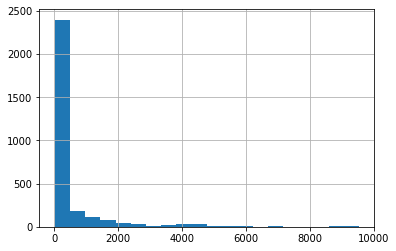

In [ ]:
meta_train['views'].hist(bins=20)

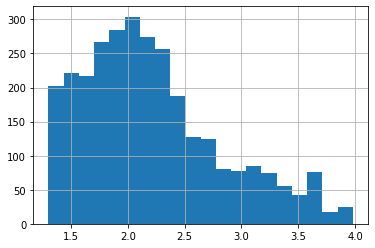

In [ ]:
np.log10(meta_train['views']).hist(bins=20)

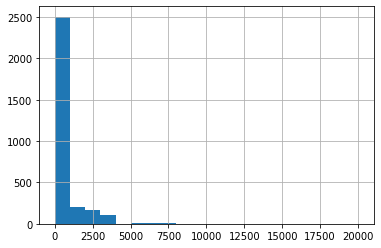

In [ ]:
meta_train['duration'].hist(bins=20)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


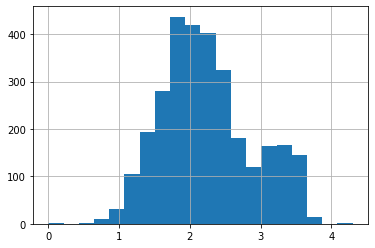

In [ ]:
duration_log = np.log10(meta_train['duration']).replace(-np.inf, 0)
duration_log.hist(bins=20)

In [ ]:
meta_train['ad_blocked'].value_counts()

False    2980
True       20
Name: ad_blocked, dtype: int64

In [ ]:
meta_train['embed'].value_counts()

True     2982
False      18
Name: embed, dtype: int64

In [ ]:
# Some of videos have inactive partners.
pd.crosstab(meta_train.partner, meta_train.partner_active)

partner_active,False,True
partner,,
False,1194,0
True,1123,683


In [ ]:
# Correlation b/w the target and numeric variables. n_likes, language, and ratio are good candidates.
cor_tbl_df = meta_train[['views', 'ratio', 'duration', 'language', 'n_likes', 'n_tags', 
                          'n_formats', 'dayofweek', 'hour']]
sort_n = cor_tbl_df.corr().sort_values('views', ascending=False).index
cor_tbl_df.corr()[sort_n].iloc[0]

views        1.000000
n_likes      0.288940
language     0.105701
ratio        0.102332
n_tags       0.081795
duration     0.073680
n_formats    0.034488
hour        -0.014262
dayofweek   -0.022092
Name: views, dtype: float64

In [ ]:
meta_train['language'].value_counts()

2     2136
4      419
9      114
5       87
6       66
3       42
7       41
10      36
1       32
8       27
Name: language, dtype: int64

In [ ]:
# With EDA above, I decided to use 'n_likes' 'language' 'ratio' and the other data points from metadata.
# One hot encoding.
# ad = pd.get_dummies(meta_train.ad_blocked, prefix ='ad') --- ad column in public set only has 1 value.
embed = pd.get_dummies(meta_train.embed, prefix ='embed')
partner = pd.get_dummies(meta_train.partner, prefix ='partner')
partner_active = pd.get_dummies(meta_train.partner_active, prefix ='partner_a')

#### JORGE
language = pd.get_dummies(meta_train['language'], prefix='language')
weekday = pd.get_dummies(meta_train['dayofweek'], prefix='day')

sin_hour = np.sin(2*np.pi*meta_train['hour']/24.0)
sin_hour.name = 'sin_hour'
cos_hour = np.cos(2*np.pi*meta_train['hour']/24.0)
cos_hour.name = 'cos_hour'
########


# Join all dataframes.
meta_final_df = pd.concat([meta_train[['comp_id', 'views', 'ratio', 'language', 'n_likes', 'duration']].reset_index(drop=True),
                           embed, partner, partner_active, language, weekday, sin_hour, cos_hour], axis=1)
meta_final_df.head()

,comp_id,views,ratio,language,n_likes,duration,embed_False,embed_True,partner_False,partner_True,partner_a_False,partner_a_True,language_1,language_2,language_3,language_4,language_5,language_6,language_7,language_8,language_9,language_10,day_1,day_2,day_3,day_4,day_5,day_7,sin_hour,cos_hour
0,1,290,1.77778,3,0,86,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1.0,6.123234e-17
1,2,1443,1.33333,2,0,1129,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.0,6.123234e-17
2,3,329,1.76667,2,0,1163,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.0,6.123234e-17
3,4,63,1.77778,2,0,1326,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.0,6.123234e-17
4,5,37,1.77273,2,3,2612,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.0,6.123234e-17


In [ ]:
title_train.head()

#### Image data has 4000 columns and would be hard to be processed with a local machine. So I decided to recude the dimentionality using Lasso regression. The rest of the datasets remain unchanged and can be joined and consolidated into one big table.

In [ ]:
image_train.head()

,comp_id,image_1,image_2,image_3,image_4,image_5,image_6,image_7,image_8,image_9,image_10,image_11,image_12,image_13,image_14,image_15,image_16,image_17,image_18,image_19,image_20,image_21,image_22,image_23,image_24,image_25,image_26,image_27,image_28,image_29,image_30,image_31,image_32,image_33,image_34,image_35,image_36,image_37,image_38,image_39,...,image_3961,image_3962,image_3963,image_3964,image_3965,image_3966,image_3967,image_3968,image_3969,image_3970,image_3971,image_3972,image_3973,image_3974,image_3975,image_3976,image_3977,image_3978,image_3979,image_3980,image_3981,image_3982,image_3983,image_3984,image_3985,image_3986,image_3987,image_3988,image_3989,image_3990,image_3991,image_3992,image_3993,image_3994,image_3995,image_3996,image_3997,image_3998,image_3999,image_4000
0,1,0.484456,0.036087,-0.149328,0.144475,-0.617386,0.035018,0.169174,-0.005733,-0.104908,-0.041200,0.780332,-0.088374,0.321899,-0.076341,-1.193367,0.076671,0.359643,-0.087548,-0.015789,0.201758,0.064355,-0.616845,0.046767,0.392215,-0.009920,0.049990,0.018078,0.198612,1.561772,0.004040,1.115828e-14,0.245002,1.398923,0.036252,-0.094207,-0.289255,-0.061230,-0.469053,0.016973,...,0.005193,-1.364837,0.006476,0.002824,-0.147828,-0.781976,0.396359,-3.690247,0.013893,-0.195668,0.206938,0.028772,1.522198,-0.606094,0.358221,0.020232,0.658431,-0.031049,0.026947,0.179981,-0.001695,-0.269223,0.070663,-0.604360,0.046013,-0.000350,0.171488,-0.067376,-0.052903,0.111028,-0.090408,-0.032915,-0.010857,-0.015954,0.123416,0.195833,-0.066449,0.115818,-0.005140,0.017278
1,2,0.074533,-0.015655,-0.016286,-0.480964,0.687917,0.037131,-0.149725,-0.002098,0.099383,-0.021134,0.410953,0.029568,0.555797,0.210486,0.797866,-0.079695,-0.103046,0.008360,-0.006162,-0.820352,0.093285,-0.257368,-0.003837,-0.237525,-0.010784,-0.127445,0.003142,0.042099,0.092049,-0.015305,1.275889e-15,-0.293696,-0.173552,0.039536,-1.181006,-0.254040,0.065191,-0.769628,0.006467,...,0.034338,0.406546,-0.045887,0.008474,0.474869,-0.552040,-0.634184,0.225877,0.023105,-0.093336,0.163543,-0.101472,1.708743,-0.204869,0.513708,0.034999,-0.510086,0.032423,-0.018788,0.252818,-0.000703,-0.000187,0.083051,0.410483,-0.020481,0.020026,0.298024,0.554534,-0.054143,-0.102448,-0.625816,-0.009616,0.004558,0.008310,-0.173496,0.133518,-0.488898,0.084832,0.146566,0.007997
2,3,-0.396809,0.021490,-1.723037,0.666147,-0.631924,0.047724,0.336041,-0.003904,0.039683,0.002628,-0.006978,-0.116380,0.048934,-0.235391,-1.849174,0.130089,-0.451063,0.065677,-0.055431,-0.669081,0.043518,-0.561830,-0.001670,0.824120,-0.022290,0.288842,0.005356,0.034002,-1.261856,-0.010268,1.328018e-14,0.486931,-0.056531,0.020430,0.187717,-0.384779,0.012771,-0.634231,-0.038821,...,0.014662,1.867043,-0.016193,-0.002900,-0.040511,1.650881,0.843204,2.086596,-0.005560,0.032179,-0.405258,0.036758,-1.253300,-0.229919,0.206761,0.071793,-0.377193,-0.047854,0.003419,-0.539637,-0.002529,0.007692,-0.077466,0.605521,0.213865,-0.010082,-0.050623,0.105038,0.144554,-0.384109,-0.078059,0.086320,-0.005606,0.002414,-0.164493,0.218473,0.151292,-0.076860,0.008321,0.012555
3,4,0.995316,0.012766,0.387472,-0.684791,-0.209261,0.013654,0.138517,0.005586,0.079277,-0.004665,-0.356708,0.194370,0.147365,0.335734,0.807046,0.202777,0.111972,-0.002998,-0.047739,0.294054,-0.000040,0.169779,-0.043684,5.531464,-0.021486,0.550411,-0.002595,-0.151196,-0.647365,-0.016672,3.251479e-14,0.082928,-0.379089,-0.084236,-0.895890,0.385392,-0.028787,0.101765,0.021869,...,0.005221,-1.364425,0.007607,0.003765,0.072319,-0.414214,0.035882,-2.780271,-0.018474,0.099804,-0.217108,0.090902,-0.199446,-0.387944,0.142761,0.043976,1.334685,-0.003364,0.000313,0.206105,0.000606,-0.200762,0.049662,0.869679,-0.049231,-0.022817,0.392719,0.330957,-0.051254,0.302376,-0.190714,-0.005452,-0.003889,0.013430,0.344406,0.038220,0.210446,-0.145128,-0.019172,0.000532
4,5,-0.611648,0.000860,-0.572393,0.894287,-0.191228,-0.111583,-0.011111,0.003231,-0.160582,0.032804,-0.260793,0.071633,-0.488627,0.050279,-0.219198,-0.176530,1.063709,

In [ ]:
# Set the target as well as dependent variables from image data.
y = meta_train['views']
x = image_train.loc[:, image_train.columns != 'comp_id']

In [ ]:
# Run Lasso regression for feature selection.
sel_model = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))

start = timeit.default_timer()
sel_model.fit(x, y)
stop = timeit.default_timer()
print('Time: ', stop - start) 

Time:  1365.7092927780013


In [ ]:
# Check how many columns are selected. 1258 columns selected.
sel_index = sel_model.get_support()
counter = collections.Counter(sel_model.get_support())
counter

Counter({False: 2742, True: 1258})

In [ ]:
# Reconstruct the image dataframe using the index information above.
image_index_df = pd.DataFrame(x[x.columns[(sel_index)]])
image_final_df = pd.concat([image_train[['comp_id']], image_index_df], axis=1)
image_final_df.head()

,comp_id,image_1,image_3,image_4,image_11,image_15,image_17,image_20,image_24,image_26,image_29,image_33,image_38,image_41,image_42,image_45,image_48,image_52,image_70,image_71,image_72,image_77,image_80,image_82,image_85,image_87,image_92,image_94,image_95,image_96,image_98,image_101,image_110,image_118,image_119,image_124,image_129,image_135,image_142,image_145,...,image_3842,image_3844,image_3845,image_3848,image_3849,image_3851,image_3856,image_3862,image_3868,image_3880,image_3889,image_3890,image_3892,image_3894,image_3897,image_3899,image_3904,image_3907,image_3910,image_3916,image_3924,image_3926,image_3929,image_3932,image_3943,image_3944,image_3946,image_3947,image_3957,image_3958,image_3959,image_3960,image_3962,image_3966,image_3968,image_3973,image_3974,image_3977,image_3984,image_3990
0,1,0.484456,-0.149328,0.144475,0.780332,-1.193367,0.359643,0.201758,0.392215,0.049990,1.561772,1.398923,-0.469053,-0.201135,0.654774,-0.010272,-2.294257,0.213377,0.363581,-0.685833,0.111829,0.674146,0.942569,0.969569,1.158182,0.195791,-0.969695,-0.477639,-0.366914,-1.913973,-0.338678,-0.023543,-1.129131,0.143965,0.677368,0.283335,-0.498193,0.270579,-0.616901,1.041734,...,-0.688167,-1.641789,-0.711524,-0.916584,0.634678,0.254656,0.295851,-0.002767,0.652335,-0.655231,-6.070977,-0.755872,1.559476,1.452236,0.453110,-0.806334,-2.051662,0.027525,1.175223,-0.257737,-1.097092,-0.375472,-0.310596,-1.836144,-7.671426,4.883176,1.104062,0.755437,-1.418211,0.571643,-0.506946,-0.162883,-1.364837,-0.781976,-3.690247,1.522198,-0.606094,0.658431,-0.604360,0.111028
1,2,0.074533,-0.016286,-0.480964,0.410953,0.797866,-0.103046,-0.820352,-0.237525,-0.127445,0.092049,-0.173552,-0.769628,-0.157064,-0.936632,-0.688076,-0.290775,-0.132548,1.046307,-0.152651,-3.680610,-1.277761,-0.318260,0.846168,0.580758,-0.061647,-0.162859,-0.044717,-0.623375,0.088911,0.658993,0.470742,-0.274444,-0.649374,0.249240,-0.888138,0.003847,-0.312809,-1.502790,0.103435,...,0.427027,0.016776,0.060192,0.054140,1.188652,-1.135208,0.213167,0.286731,-0.022780,-1.274276,-2.541646,-0.019520,-0.034465,0.126218,-0.679646,-0.719898,-0.798027,0.288983,0.795949,0.676574,0.198020,0.380690,-1.350619,-0.624966,-2.278313,-0.468203,0.066688,0.640690,-1.703507,0.103802,1.284343,0.019412,0.406546,-0.552040,0.225877,1.708743,-0.204869,-0.510086,0.410483,-0.102448
2,3,-0.396809,-1.723037,0.666147,-0.006978,-1.849174,-0.451063,-0.669081,0.824120,0.288842,-1.261856,-0.056531,-0.634231,-0.084242,-1.114264,-0.298926,-3.862903,-0.428824,1.242752,1.301610,1.750511,1.105347,-1.283686,0.756559,-0.023867,-0.028867,-0.873462,0.450887,-0.183318,0.161405,-0.540422,1.064937,-0.858482,0.613253,-0.063294,0.069435,0.253167,0.167378,-1.982087,-1.047908,...,0.561813,-1.538254,-1.140233,-1.490336,-1.057393,-0.709770,0.127387,-0.197847,-1.031728,-1.601098,-12.186877,-0.974039,0.493728,1.894651,0.715750,0.588887,-1.315847,-0.515519,-0.782052,-0.009799,0.318188,-0.651851,0.855341,-2.795952,0.263273,0.881765,-1.237637,-0.549863,0.819358,-1.341328,-0.249109,-0.389832,1.867043,1.650881,2.086596,-1.253300,-0.229919,-0.377193,0.605521,-0.384109
3,4,0.995316,0.387472,-0.684791,-0.356708,0.807046,0.111972,0.294054,5.531464,0.550411,-0.647365,-0.379089,0.101765,-1.159466,-0.041758,0.125642,-3.310392,-0.969488,2.218117,-0.137710,0.491617,0.312859,-0.837037,0.592292,-0.102958,0.175682,-0.490302,1.144010,0.095253,-0.355241,-1.071852,0.707317,-0.946907,-0.307078,-0.699664,-0.374121,-0.456004,0.831626,-0.362749,-1.570100,...,-0.010726,-0.972188,-0.498447,-0.833010,-0.043913,0.268160,-0.118007,0.461594,-0.793570,-0.413192,-1.251479,0.456172,-0.045441,1.432179,0.436345,-0.341799,0.597015,-0.794545,0.671484,0.701167,0.066750,0.866278,-1.337706,0.618288,0.385956,-0.200553,-0.148386,0.870408,-1.743515,0.721996,1.032519,-0.087203,-1.364425,-0.414214,-2.780271,-0.199446,-0.387944,1.334685,0.869679,0.302376
4,5,-0.611648,-0.572393,0.894287,-0.260793,-0.219198,1.063709,0.717563,1.603678,-0.398335,0.292458,0.996249,0.843059,-1.151790,0.423280,-

In [ ]:
# Merge all tables.
final_df = pd.merge(pd.merge(meta_final_df, image_final_df, on = 'comp_id'), 
                    pd.merge(desc_train, title_train, on = 'comp_id'), on = 'comp_id')
final_df.shape

(3000, 1388)

In [ ]:
# Convert dataframe to numpy array.
X = final_df.drop(['comp_id', 'views'], axis=1).to_numpy()
y = final_df.loc[:, 'views'].to_numpy()

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 121)
print('Training set shape ', X_train.shape)
print('Test set shape ', X_test.shape)

Training set shape  (2100, 1386)
Test set shape  (900, 1386)


In [ ]:
# Test set
# public metadata
# p_ad = pd.get_dummies(meta_test.ad_blocked, prefix ='ad') --- ad column in public set only has 1 value.
p_embed = pd.get_dummies(meta_test.embed, prefix ='embed')
p_partner = pd.get_dummies(meta_test.partner, prefix ='partner')
p_partner_active = pd.get_dummies(meta_test.partner_active, prefix ='partner_a')

#### JORGE
p_language = pd.get_dummies(meta_test['language'], prefix='language')
p_language['language_6'] = 0
p_weekday = pd.get_dummies(meta_test['dayofweek'], prefix='day')
p_weekday['day_3'] = 0
p_weekday['day_4'] = 0
p_weekday['day_5'] = 0

seconds_in_day = 24*60*60

p_sin_hour = np.sin(2*np.pi*meta_test['hour']/24.0)
p_sin_hour.name = 'sin_hour'
p_cos_hour = np.cos(2*np.pi*meta_test['hour']/24.0)
p_cos_hour.name = 'cos_hour'
########

# Join all dataframes.
p_meta_final_df = pd.concat([meta_test[['comp_id', 'ratio', 'language', 'n_likes', 'duration']].reset_index(drop=True),
                             p_embed, p_partner, p_partner_active, p_language, p_weekday, p_sin_hour, p_cos_hour], axis=1)
p_meta_final_df.head()

,comp_id,ratio,language,n_likes,duration,embed_False,embed_True,partner_False,partner_True,partner_a_False,partner_a_True,language_1,language_2,language_3,language_4,language_5,language_7,language_8,language_9,language_10,language_6,day_1,day_2,day_6,day_7,day_3,day_4,day_5,sin_hour,cos_hour
0,3001,1.33333,2,0,1675,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.707107,0.707107
1,3002,1.33333,2,0,1479,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.707107,0.707107
2,3003,1.33333,2,0,1505,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.707107,0.707107
3,3004,1.77778,2,1,50,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.707107,0.707107
4,3005,1.33333,2,0,1543,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.707107,0.707107


In [ ]:
# Reconstruct the test image dataframe with the index information used for the training set.
# image_index_df = pd.DataFrame(x[x.columns[(sel_index)]])
p_image_final_df = pd.concat([image_test[['comp_id']], image_index_df], axis=1)

In [ ]:
# Merge all test set tables.
p_final_df = pd.merge(pd.merge(p_meta_final_df, p_image_final_df, on = 'comp_id'), 
                    pd.merge(desc_test, title_test, on = 'comp_id'), on = 'comp_id')
p_final_df.shape

(986, 1388)

### XGBoost

In [ ]:
### XGBoost ###
# Create Xgboost classifier.
# Create labels for both training and testing and convert dataframes into DMatrix.
# Convert dataframe to numpy array.
X = final_df.drop(['comp_id', 'views'], axis=1)
y = final_df.loc[:, 'views']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 101)
print('Training set shape ', X_train.shape)
print('Test set shape ', X_test.shape)

Training set shape  (2250, 1386)
Test set shape  (750, 1386)


In [ ]:
trlabel = y_train
telabel = y_test

dtrain = xgb.DMatrix(X_train, label=trlabel)
dtest  = xgb.DMatrix(X_test, label=telabel)

In [ ]:
# Set parameters.
param = {'max_depth': 7, 
         'eta': 0.2,
         'objective': 'reg:squarederror',
         'nthread': 5,
         'eval_metric': 'rmse'
        }

evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [ ]:
# Train the model.
num_round = 70
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-rmse:1246.65	train-rmse:1194.55
[1]	eval-rmse:1205.62	train-rmse:1090.53
[2]	eval-rmse:1179.74	train-rmse:995.81
[3]	eval-rmse:1162.69	train-rmse:929.312
[4]	eval-rmse:1149.05	train-rmse:846.666
[5]	eval-rmse:1140.69	train-rmse:783.953
[6]	eval-rmse:1130.96	train-rmse:748.987
[7]	eval-rmse:1124.33	train-rmse:704.769
[8]	eval-rmse:1110.91	train-rmse:649.108
[9]	eval-rmse:1110.11	train-rmse:619.634
[10]	eval-rmse:1106.81	train-rmse:591.443
[11]	eval-rmse:1107.56	train-rmse:578.922
[12]	eval-rmse:1109.54	train-rmse:558.348
[13]	eval-rmse:1112.39	train-rmse:543.411
[14]	eval-rmse:1107.89	train-rmse:513.365
[15]	eval-rmse:1108.3	train-rmse:491.456
[16]	eval-rmse:1111.45	train-rmse:467.432
[17]	eval-rmse:1119.49	train-rmse:444.935
[18]	eval-rmse:1118.99	train-rmse:427.441
[19]	eval-rmse:1120.57	train-rmse:402.541
[20]	eval-rmse:1123.23	train-rmse:385.132
[21]	eval-rmse:1123.21	train-rmse:363.861
[22]	eval-rmse:1125.28	train-rmse:344.283
[23]	eval-rmse:1124.28	train-rmse:316.841
[24]

In [ ]:
# Make prediction.
ypred = bst.predict(dtest).round()

In [ ]:
# Compute RMSE on test set.
mse_xgboost = mean_squared_error(y_test, ypred)
rmse_xgboost = math.sqrt(mse_xgboost)

print('RMSE with XGBoost', rmse_xgboost)

RMSE with XGBoost 1133.909102177066


In [ ]:
# Make preictions on public data. - XGBoost
d_public = xgb.DMatrix(p_final_df.loc[:, p_final_df.columns != 'comp_id'][bst.feature_names])
solution = bst.predict(d_public).round()
solution_df = pd.concat([p_final_df[['comp_id']], pd.DataFrame(solution, columns = ['views'])], axis=1)
solution_df.to_csv('xgb_3.csv', index=False)

In [ ]:
np.exp(-rmse_xgboost/max(y_test)).round(8)

0.8848065

In [ ]:
solution = pd.read_csv('xgb_3.csv')
solution.head()

,comp_id,views
0,3001,266.0
1,3002,1108.0
2,3003,267.0
3,3004,3183.0
4,3005,294.0
